In [1]:
# Install dependencies (only needed in Google Colab)
# In Azure Databricks, skip this cell
!pip install pyspark==3.5.1 delta-spark==3.1.0
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

In [2]:
# using DELTA in colab
!pip install delta-spark==3.2.0 -q
import pyspark
from delta import *
from pyspark.sql.functions import *

# Create a SparkSession with Delta Lake extensions
# The '.config(...)' lines are crucial for enabling Delta Lake's features
builder = pyspark.sql.SparkSession.builder.appName("DeltaDemo") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Get or create the SparkSession
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("Spark and Delta Lake are ready!")

Spark and Delta Lake are ready!


# Dataset Creation

In [3]:
# Create sample DataFrame
data = [
        (1, "John", "Electronics", 2, 300),
        (2, "Sara", "Clothing", 1, 50),
        (3, "Mike", "Electronics", 4, 600),
        (4, "Nina", "Clothing", 3, 150),
]
columns = ["order_id", "customer_name", "category", "quantity", "amount"]
df = spark.createDataFrame(data, columns)

In [4]:
# Save as Delta table
df.write.format("delta").mode("overwrite").save("/tmp/orders_delta")

# Display
display(spark.read.format("delta").load("/tmp/orders_delta"))

# Show
df.show()

DataFrame[order_id: bigint, customer_name: string, category: string, quantity: bigint, amount: bigint]

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
+--------+-------------+-----------+--------+------+



# Exercise Set

# 1. Managed vs Unmanaged Tables

Create a managed table
orders_managed from
/tmp/orders_delta

In [5]:
# Managed Table
spark.sql("CREATE TABLE IF NOT EXISTS orders_managed USING DELTA LOCATION '/tmp/orders_delta'")

# Unmanaged Table
spark.sql("CREATE TABLE IF NOT EXISTS orders_unmanaged USING DELTA LOCATION '/tmp/orders_delta'")

spark.sql("SHOW TABLES").show()

+---------+----------------+-----------+
|namespace|       tableName|isTemporary|
+---------+----------------+-----------+
|  default|  orders_managed|      false|
|  default|orders_unmanaged|      false|
+---------+----------------+-----------+



# 2. CRUD Operations

 Read from the table


In [6]:
from delta.tables import DeltaTable

orders_tbl = DeltaTable.forPath(spark, "/tmp/orders_delta")
# Read from the table
spark.sql("SELECT * FROM orders_managed").show()

spark.sql("SELECT * FROM orders_unmanaged").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



Update all "Clothing" category orders to have
amount = amount + 20

In [7]:
orders_tbl.update(
    condition="category = 'Clothing'",
    set={"amount": "amount + 20"}
)

spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    70|
+--------+-------------+-----------+--------+------+



Delete all orders with
quantity < 2

In [8]:
spark.sql("DELETE FROM orders_managed WHERE quantity < 2")

spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       2|   300|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



 Merge in a new dataset (new orders & updated orders)

In [9]:
new_data = [
    (1, "John", "Electronics", 5, 750),  # Updated
    (5, "Anu", "Electronics", 4, 670),  # New
]

columns = ["order_id", "customer_name", "category", "quantity", "amount"]
new_df = spark.createDataFrame(new_data, columns)

orders_tbl.alias("old").merge(
    new_df.alias("new"),
    "old.order_id = new.order_id"
).whenMatchedUpdateAll(
).whenNotMatchedInsertAll().execute()

spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       5|   750|
|       5|          Anu|Electronics|       4|   670|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



# 3. History & Time Travel

 Use
DESCRIBE HISTORY to check previous versions

In [10]:
(spark.sql("DESCRIBE HISTORY orders_managed")).show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|     15|2025-08-14 08:10:...|  NULL|    NULL|    MERGE|{predicate -> ["(...|NULL|    NULL|     NULL|         14|  Serializable|        false|{numTargetRowsCop...|        NULL|Apache-Spark/3.5....|
|     14|2025-08-14 08:10:...|  NULL|    NULL|   DELETE|{predicate -> ["(...|NULL|    NULL|     NULL|         13|  Serializable|        false|{numRemovedFiles ...|        NULL|Apache-Spark/3.5....|
|     13|2

 Read data from version 0 and compare with the latest version

In [11]:
# 1. Read version 0
old_df = spark.read.format("delta").option("versionAsOf", 0).load("/tmp/orders_delta")
print("Version 0:")
old_df.show()

Version 0:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   150|
|       1|         John|Electronics|       2|   300|
|       2|         Sara|   Clothing|       1|    50|
+--------+-------------+-----------+--------+------+



In [12]:
# 2. Read latest version
latest_df = spark.read.format("delta").load("/tmp/orders_delta")
print("Latest Version:")
latest_df.show()

Latest Version:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       5|   750|
|       5|          Anu|Electronics|       4|   670|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



In [13]:
# 3. Find rows that changed between version 0 and latest
changes = latest_df.subtract(old_df)
print("Comparison of Version 0 and Latest:")
changes.show()

Comparison of Version 0 and Latest:
+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       5|          Anu|Electronics|       4|   670|
|       1|         John|Electronics|       5|   750|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



# 4. Incremental Load Pattern

Create a new mini-batch with only new orders

In [14]:
new_batch = [
    (6, "Sandeep", "Clothing", 4, 800),
    (7, "Jessy", "Electronics", 2, 600),
]

 Append to the Delta table

In [15]:
# Create DataFrame
new_df = spark.createDataFrame(new_batch, columns)

new_df.write.format("delta").mode("append").save("/tmp/orders_delta")

 Show final result

In [16]:
spark.sql("SELECT * FROM orders_managed").show()

+--------+-------------+-----------+--------+------+
|order_id|customer_name|   category|quantity|amount|
+--------+-------------+-----------+--------+------+
|       1|         John|Electronics|       5|   750|
|       5|          Anu|Electronics|       4|   670|
|       7|        Jessy|Electronics|       2|   600|
|       6|      Sandeep|   Clothing|       4|   800|
|       3|         Mike|Electronics|       4|   600|
|       4|         Nina|   Clothing|       3|   170|
+--------+-------------+-----------+--------+------+



# 5. Simple Streaming Read

 Read the
/tmp/orders_delta in streaming mode

In [17]:
streaming_df = spark.readStream.format("delta").load("/tmp/orders_delta")

 Output to console every 5 seconds

In [18]:
query = (
    streaming_df.writeStream
    .format("console")
    .outputMode("append")
    .trigger(processingTime="5 seconds")
    .start()
)

import time
time.sleep(20)

query.stop()

# 6. Visualization

 Read Delta table into Pandas

In [19]:
import pandas as pd

df = spark.read.format("delta").load("/tmp/orders_delta").toPandas()
df

,order_id,customer_name,category,quantity,amount
0,1,John,Electronics,5,750
1,5,Anu,Electronics,4,670
2,7,Jessy,Electronics,2,600
3,6,Sandeep,Clothing,4,800
4,3,Mike,Electronics,4,600
5,4,Nina,Clothing,3,170


Create a bar chart of
category vs
total amount

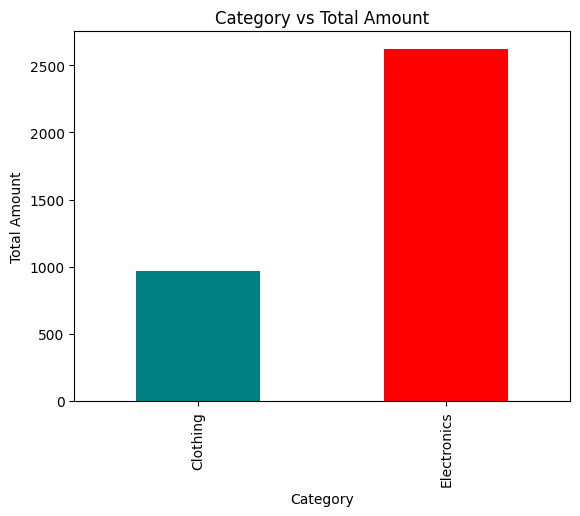

In [21]:
import matplotlib.pyplot as plt

category_amount = df.groupby("category")["amount"].sum()
category_amount.plot(kind="bar", color=["teal", "red"])
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.title("Category vs Total Amount")
plt.show()